In [10]:
from GT import get_dataset, denormalize
import matplotlib.pyplot as plt
from GT import GTLSTM
import json
import torch
from MMD import mmd_poly, mmd_linear, mmd_rbf
import numpy as np
import os
from tsl.datasets import MetrLA, MetrLA, PemsBay

DATASET_NAME = 'MetrLA'
MODEL_NAME= 'GTLSTM'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [11]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [12]:
# Model Parameters 100 hidden
hidden_size = 64
num_layers = 1
lr = 0.1 
dropout = 0
bidirectional = True
debug = False
train_from_checkpoint = False
dataset = MetrLA()


## Dataset

In [13]:
dataset = dataset.dataframe()[-5000:]

In [14]:
dataset

nodes,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
channels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-06-10 15:20:00,67.000000,68.000000,66.000000,21.000000,52.000000,37.000000,64.000000,67.000000,65.000000,70.000000,...,32.000000,70.000000,66.000000,67.714287,68.000000,64.000000,70.000000,60.000000,70.000000,64.000000
2012-06-10 15:25:00,67.000000,68.000000,66.000000,21.000000,52.000000,37.000000,64.000000,67.000000,65.000000,70.000000,...,32.000000,70.000000,66.000000,67.714287,68.000000,64.000000,70.000000,60.000000,70.000000,64.000000
2012-06-10 15:30:00,67.000000,68.000000,66.000000,21.000000,52.000000,37.000000,64.000000,67.000000,65.000000,70.000000,...,32.000000,70.000000,66.000000,67.714287,68.000000,64.000000,70.000000,60.000000,70.000000,64.000000
2012-06-10 15:35:00,67.000000,68.000000,66.000000,21.000000,52.000000,37.000000,64.000000,67.000000,65.000000,70.000000,...,32.000000,70.000000,66.000000,67.714287,68.000000,64.000000,70.000000,60.000000,70.000000,64.000000
2012-06-10 15:40:00,68.666664,66.666664,69.333336,52.333332,45.333332,62.000000,61.000000,66.000000,67.666664,68.000000,...,33.000000,68.000000,66.666664,68.000000,70.000000,66.000000,70.000000,52.333332,59.666668,65.666664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-27 23:35:00,65.000000,65.888885,68.555557,61.666668,32.833332,54.555557,62.444443,63.333332,59.222221,65.333336,...,52.888889,69.000000,65.111115,55.666668,66.333336,62.444443,66.777779,64.888885,69.666664,62.333332
2012-06-27 23:40:00,61.375000,65.625000,66.500000,62.750000,32.833332,50.500000,62.000000,67.000000,65.250000,67.125000,...,54.000000,69.250000,60.125000,60.500000,67.250000,59.375000,66.000000,61.250000,69.000000,62.000000
2012-06-27 23:45:00,67.000000,59.666668,69.555557,61.000000,32.833332,44.777779,64.222221,63.777779,59.777779,57.666668,...,51.333332,67.888885,64.333336,57.000000,66.000000,62.666668,68.666664,63.333332,67.444443,61.222221


In [15]:
# Dataset Split\
Train, Validation, Test = get_dataset('MetrLA', dataset=dataset)

train_data = Train
train_data = torch.Tensor(train_data)
train_label = train_data
train_data = train_data[:-1]
train_label = train_label[1:]

validation_data = Validation
validation_data = torch.Tensor(validation_data)
validation_label = validation_data
validation_data = validation_data[:-1]
validation_label = validation_label[1:]

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)

MetrLA DATA
________________________________________
Original Dataset: 	5000
Train Split: 		4500 	(70%)
Validation Split: 	250 	(20%)
Test Split: 		250 	(10%)
________________________________________


## Model Train

In [16]:
# Model Train
model = GTLSTM(input_size, output_size, hidden_size, dropout, num_layers, bidirectional, 'mse', lr, ['EarlyStopping'], DEVICE)

configs = input_size, output_size, hidden_size, dropout, num_layers, bidirectional, 'mse', lr, ['EarlyStopping']
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, train_label, 32, 25, 10)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

Model not present or incompatible
Starting training...


Loss 0.013307288457500809, MAE : 0.08400803146527168: 100%|██████████| 141/141 [00:17<00:00,  8.10it/s]


Epoch 1 - MSE: 0.013307288457500809 - MAE: 0.08400803146527168


Loss 0.0118400187905323, MAE : 0.07773354546503818: 100%|██████████| 141/141 [00:17<00:00,  8.15it/s]  


Epoch 2 - MSE: 0.0118400187905323 - MAE: 0.07773354546503818


Loss 0.01098805791797473, MAE : 0.07396961376070976: 100%|██████████| 141/141 [00:17<00:00,  8.16it/s] 


Epoch 3 - MSE: 0.01098805791797473 - MAE: 0.07396961376070976


Loss 0.01045715013281145, MAE : 0.0716118594591922: 100%|██████████| 141/141 [00:17<00:00,  8.27it/s]  


Epoch 4 - MSE: 0.01045715013281145 - MAE: 0.0716118594591922


Loss 0.010101480179974903, MAE : 0.07005387417813565: 100%|██████████| 141/141 [00:17<00:00,  8.10it/s]


Epoch 5 - MSE: 0.010101480179974903 - MAE: 0.07005387417813565


Loss 0.009844064098247823, MAE : 0.06894531219880631: 100%|██████████| 141/141 [00:17<00:00,  8.25it/s]


Epoch 6 - MSE: 0.009844064098247823 - MAE: 0.06894531219880631


Loss 0.00964274859808861, MAE : 0.06809556510642911: 100%|██████████| 141/141 [00:17<00:00,  8.28it/s] 


Epoch 7 - MSE: 0.00964274859808861 - MAE: 0.06809556510642911


Loss 0.009473941460621695, MAE : 0.06739522873404179: 100%|██████████| 141/141 [00:17<00:00,  8.25it/s]


Epoch 8 - MSE: 0.009473941460621695 - MAE: 0.06739522873404179


Loss 0.009324251375233768, MAE : 0.06677902796378372: 100%|██████████| 141/141 [00:17<00:00,  8.12it/s]


Epoch 9 - MSE: 0.009324251375233768 - MAE: 0.06677902796378372


Loss 0.009186006012432118, MAE : 0.0662127657667965: 100%|██████████| 141/141 [00:17<00:00,  8.13it/s] 


Epoch 10 - MSE: 0.009186006012432118 - MAE: 0.0662127657667965


Loss 0.009054791155859089, MAE : 0.06567546009277621: 100%|██████████| 141/141 [00:17<00:00,  8.17it/s]


Epoch 11 - MSE: 0.009054791155859089 - MAE: 0.06567546009277621


Loss 0.008928076223741081, MAE : 0.06515485138123762: 100%|██████████| 141/141 [00:17<00:00,  8.25it/s]


Epoch 12 - MSE: 0.008928076223741081 - MAE: 0.06515485138123762


Loss 0.00880443972720375, MAE : 0.06464261915666837: 100%|██████████| 141/141 [00:17<00:00,  8.12it/s] 


Epoch 13 - MSE: 0.00880443972720375 - MAE: 0.06464261915666837


Loss 0.008683126764900401, MAE : 0.06413589288473975: 100%|██████████| 141/141 [00:17<00:00,  8.24it/s] 


Epoch 14 - MSE: 0.008683126764900401 - MAE: 0.06413589288473975


Loss 0.008563793718431753, MAE : 0.06363286986841378: 100%|██████████| 141/141 [00:17<00:00,  8.25it/s]


Epoch 15 - MSE: 0.008563793718431753 - MAE: 0.06363286986841378


Loss 0.008446356915730112, MAE : 0.06313242261291396: 100%|██████████| 141/141 [00:17<00:00,  8.12it/s]


Epoch 16 - MSE: 0.008446356915730112 - MAE: 0.06313242261291396


Loss 0.008330899365048142, MAE : 0.06263482108289468: 100%|██████████| 141/141 [00:17<00:00,  8.02it/s]


Epoch 17 - MSE: 0.008330899365048142 - MAE: 0.06263482108289468


Loss 0.008217610986837258, MAE : 0.06214077382328662: 100%|██████████| 141/141 [00:17<00:00,  8.27it/s]


Epoch 18 - MSE: 0.008217610986837258 - MAE: 0.06214077382328662


Loss 0.00810674773958505, MAE : 0.06165153018020569: 100%|██████████| 141/141 [00:17<00:00,  8.15it/s] 


Epoch 19 - MSE: 0.00810674773958505 - MAE: 0.06165153018020569


Loss 0.00799860022730914, MAE : 0.06116903335490125: 100%|██████████| 141/141 [00:17<00:00,  8.09it/s]  


Epoch 20 - MSE: 0.00799860022730914 - MAE: 0.06116903335490125


Loss 0.007893470165498078, MAE : 0.06069498540873223: 100%|██████████| 141/141 [00:17<00:00,  8.22it/s] 


Epoch 21 - MSE: 0.007893470165498078 - MAE: 0.06069498540873223


Loss 0.007791650422075962, MAE : 0.060230696692745736: 100%|██████████| 141/141 [00:17<00:00,  8.15it/s]


Epoch 22 - MSE: 0.007791650422075962 - MAE: 0.060230696692745736


Loss 0.007693408488078003, MAE : 0.059778266104189216: 100%|██████████| 141/141 [00:17<00:00,  8.07it/s]


Epoch 23 - MSE: 0.007693408488078003 - MAE: 0.059778266104189216


Loss 0.00759897447944163, MAE : 0.05933894415168052: 100%|██████████| 141/141 [00:17<00:00,  8.12it/s]  


Epoch 24 - MSE: 0.00759897447944163 - MAE: 0.05933894415168052


Loss 0.007508530435053275, MAE : 0.058913712568105535: 100%|██████████| 141/141 [00:17<00:00,  8.28it/s]

Epoch 25 - MSE: 0.007508530435053275 - MAE: 0.058913712568105535


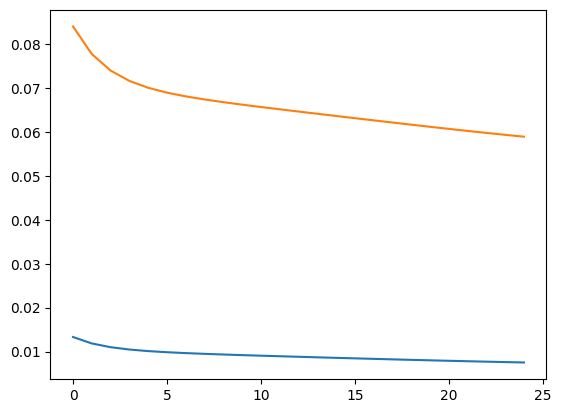

<Figure size 640x480 with 0 Axes>

In [17]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

## Predict on Train

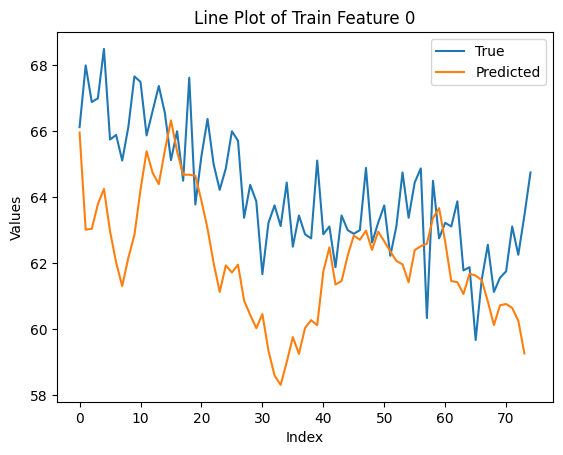

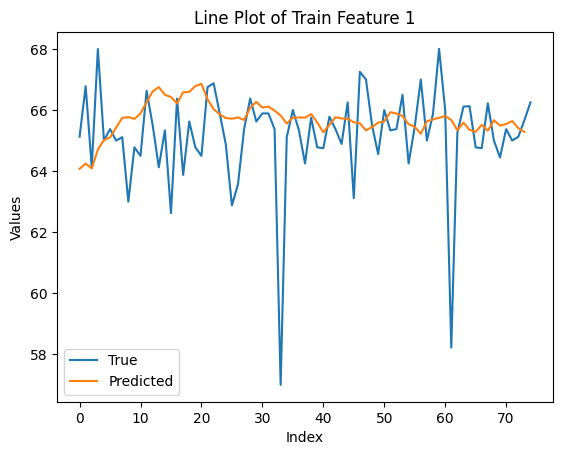

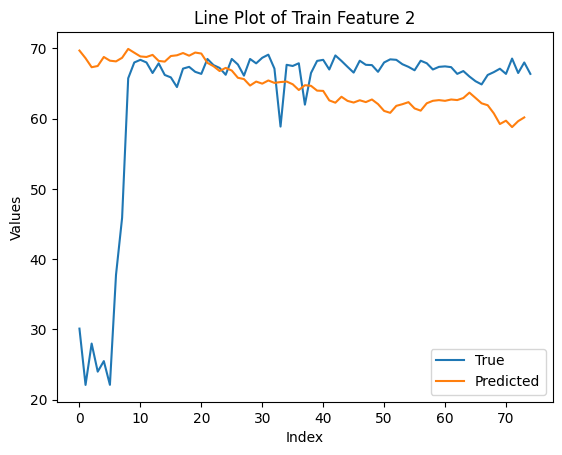

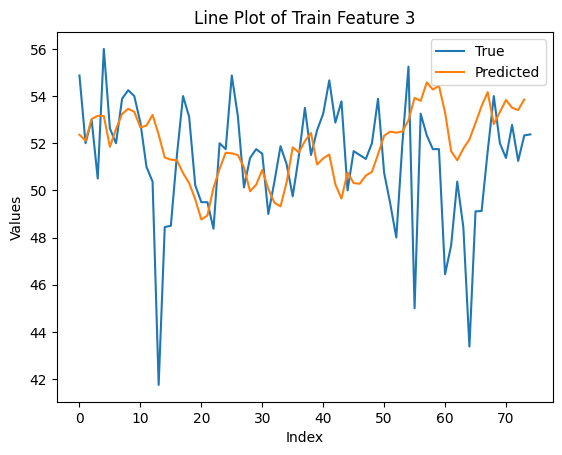

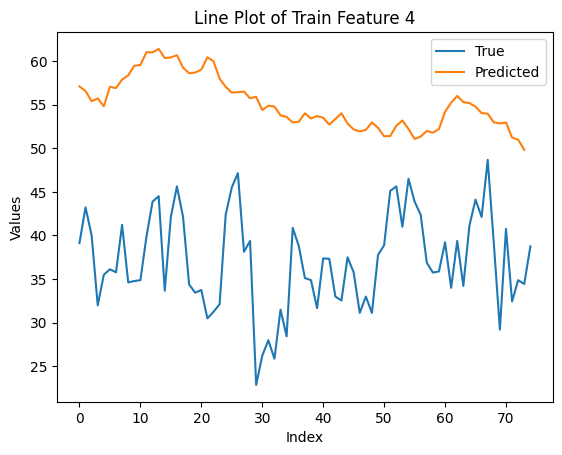

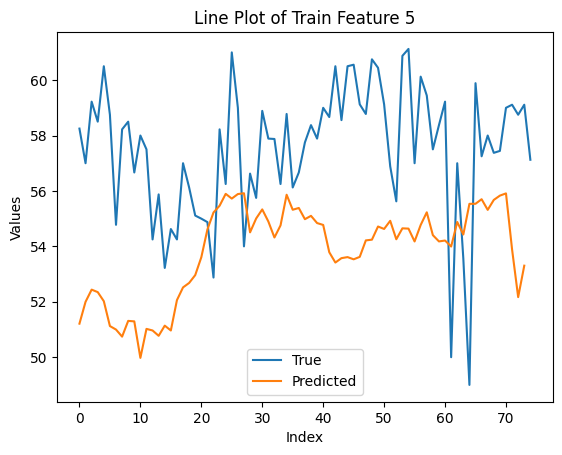

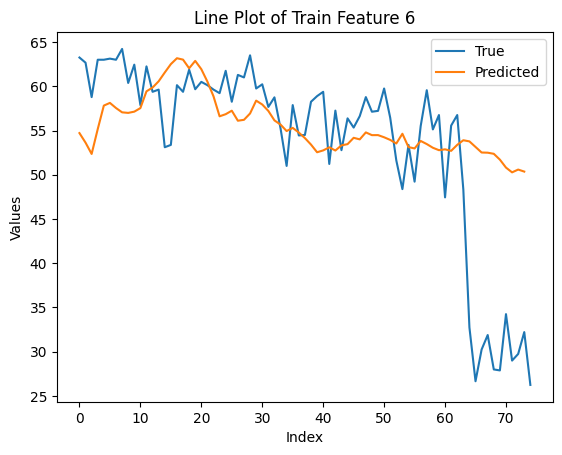

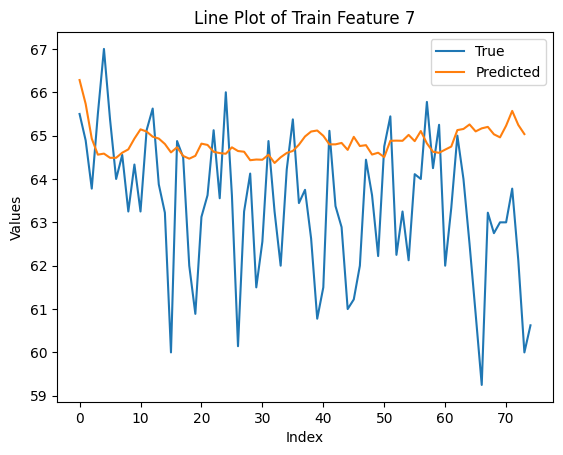

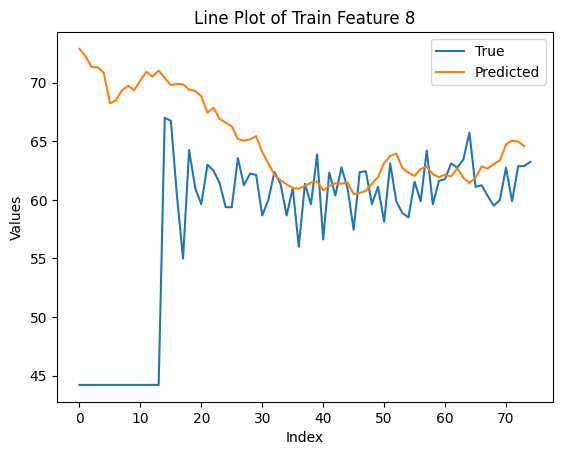

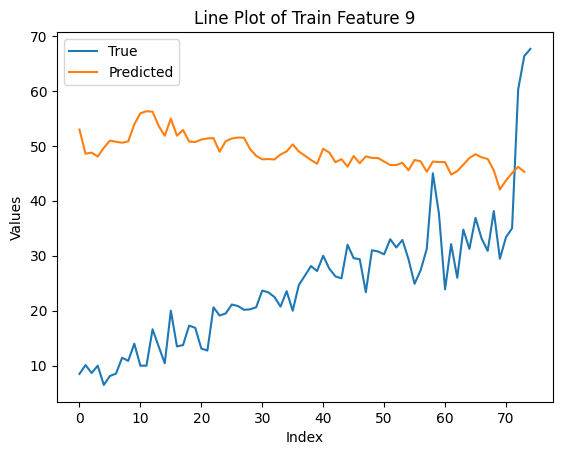

<Figure size 640x480 with 0 Axes>

In [66]:
SPLIT_NAME = 'Train'

# output = denormalize(model.predict_step(train_data, start=0, steps=50, mode='sum'))
output = model.predict_step(train_data, start=25, steps=75)

# data_true = denormalize(train_label[0:50, :, :].numpy())
data_true = train_label[25:100, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='MetrLA')
data_predicted = denormalize(data_predicted, name='MetrLA')
for i in range(10):
    first_elements_arr1 = [subarr[i] for subarr in data_true]
    first_elements_arr2 = [subarr[i] for subarr in data_predicted]
    # Plotting
    plt.plot(first_elements_arr1, label='True')
    plt.plot(first_elements_arr2, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Line Plot of Train Feature {i}')
    plt.legend()
    plt.show()
    plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}.png')
    plt.clf()

## Generate on Train

In [67]:
# output = denormalize(model.generate_step(train_data, start=0, steps=200, mode='mean'))
output = model.generate_step(train_data, start=0, steps=1000)

# data_true = denormalize(train_label[0:200, :, :].numpy())
data_true = train_label[25:100, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='MetrLA')
data_predicted = denormalize(data_predicted, name='MetrLA')

# for i in range(10):
#     first_elements_arr1 = [subarr[i] for subarr in data_true]
#     first_elements_arr2 = [subarr[i] for subarr in data_predicted]
#     # Plotting
#     plt.plot(first_elements_arr1, label='True')
#     plt.plot(first_elements_arr2, label='Generated')
#     plt.xlabel('Index')
#     plt.ylabel('Values')
#     plt.title(f'Line Plot of Train Feature {i}')
#     plt.legend()
#     plt.show()
#     plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}_GEN.png')
#     plt.clf()

In [68]:
import pandas as pd
df = pd.DataFrame(data_predicted)
str = [773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,768066,772140,773927,760024,774012,774011,767609,769359,760650,716956,769831,761604,717495,716554,773953,767470,716955,764949,773954,767366,769444,773939,774067,769443,767750,767751,767610,773880,764766,717497,717490,717491,717492,717493,765176,717498,717499,765171,718064,718066,765164,769431,769430,717610,767053,767621,772596,772597,767350,767351,716571,773023,767585,773024,717483,718379,717481,717480,717486,764120,772151,718371,717489,717488,717818,718076,718072,767455,767454,761599,717099,773916,716968,769467,717576,717573,717572,717571,717570,764760,718089,769847,717608,767523,716942,718090,769867,717472,717473,759591,764781,765099,762329,716953,716951,767509,765182,769358,772513,716958,718496,769346,773904,718499,764853,761003,717502,759602,717504,763995,717508,765265,773996,773995,717469,717468,764106,717465,764794,717466,717461,717460,717463,717462,769345,716943,772669,717582,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373]

In [69]:
df.columns = str
df.to_csv('synteticMetrLAGTLSTM.csv', index=False)

In [70]:

print(mmd_linear(data_true, data_predicted))  # 6.0
print(mmd_rbf(data_true, data_predicted))  # 0.5822
print(mmd_poly(data_true, data_predicted))  # 2436.5

15992.788
0.9942743182182312
24187437056.0
